In [1]:
import datetime
#import logging
import os

from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Ustalamy tu stałą DEVICE, która globalnie definiuje jakiego urządzenia ma użyć tensorflow. W komórkach poniżej jest kod, który upewnia się że odpowiednie urządzenie jest używane. Nie musimy dalej się martwić o przerzucanie pojedynczych wektorów pomiędzy urządzeniami

In [2]:
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
DEVICE = "GPU"

keras.backend.clear_session()

#logging.basicConfig(format='%(levelname)s: %(message)s')
#logger = logging.getLogger(__name__)
#logger.setLevel(logging.DEBUG)

In [4]:
if DEVICE == 'GPU':
    gpu = tf.config.list_physical_devices('GPU')
    assert gpu
    tf.config.experimental.set_memory_growth(gpu[0], True)  # dodatkowa opcja, gdy jest mało pamięci na karcie. Dzięki niej, tenosrflow bardzo ostrożnie nią zarządza

elif DEVICE == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    assert tf.config.list_logical_devices('TPU')

else:
    tf.config.set_visible_devices([], 'GPU')
    tf.config.set_visible_devices([], 'TPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type not in ['GPU', 'TPU']

2022-01-05 12:38:57.670919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 12:38:57.678204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 12:38:57.678502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**Funkcje pomocniczne**
* get_logdir -- tworzy podfolder do każdego trenowania modelu. Poprawia organizacje pracy z TensorBoard
* plot_training -- szybkie, proste rysowanie metryk uczenia. Przydatne gdy nie ma potrzeby używania całego TensorBoard
* mount_drive -- podpina dysk google przy pracy na Collab

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir=./logs --port=6006
def get_logdir(root_logdir=None):
    if not root_logdir:
        root_logdir = os.path.join(os.curdir, "logs")
    run_id = datetime.datetime.now().strftime("run_%Y-%m-%d_%H:%M:%S")
    return os.path.join(root_logdir, run_id)


def plot_training(history, limit_grid=None, filepath=""):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    if limit_grid:
        plt.gca().set_ylim(*limit_grid)
    if filepath:
        plt.savefig(filepath)
    plt.show()


def mount_drive():
    from google.colab import drive
    drive.mount('/content/drive')

    return '/content/drive/My Drive/'

# Quickstart

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Szybka normalizacja danych
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [8]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2288 - accuracy: 0.9319 - val_loss: 0.1096 - val_accuracy: 0.9673
Epoch 2/3
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0931 - accuracy: 0.9710 - val_loss: 0.1164 - val_accuracy: 0.9673
Epoch 3/3
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0622 - accuracy: 0.9802 - val_loss: 0.0869 - val_accuracy: 0.9747


In [9]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0740 - accuracy: 0.9767


[0.07398676127195358, 0.9767000079154968]

# In-depth modelling

TensorFlow zaiwera wiele warstw do preprocessingu, jest to wygodne bo możemy połączyć preprocessing z siecią i finalnie karmić model surowymi danymi.
Różne ciekawe warstwy:
* Normalization
* Discretization
* TextVectorization
* CategoryEncoding
* ... 

W tej kategorii są również warstwy za pomocą których możemy robić augmentacje obrazu (te warstwy będą aktywne tylko w czasie treningu, potem możemy je nawet odrzucić)
* RandomCrop
* RandomFlip
* ...

In [10]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
preprocessing_layer = tf.keras.layers.Normalization(axis=None)
preprocessing_layer.adapt(X_train)  # adaptujemy / fitujemy warstwę normalizującą na całym zbiorze treningowym

*Wszystkie poniższe metody tworzenia modelu są równoważne, uczymy je w ten sam sposób*

## Sequential API -- szybkie, proste

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    preprocessing_layer,  # dorzucamy gotowy preprocessing do modelu
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

## Functional API -- pośrednie. Przydatne gdy model nie jest sekwencyjny -- np. rozdwojone wyjście, skipowe połączenia itp

In [12]:
input_layer = keras.layers.Input(shape=(28, 28))
flatten = keras.layers.Flatten()(input_layer)
preprocess = preprocessing_layer(flatten)
dense1 = keras.layers.Dense(300, activation="relu")(preprocess)
dense2 = keras.layers.Dense(100, activation="relu")(dense1)
output_layer = keras.layers.Dense(10, activation="softmax")(dense2)

model = keras.Model(inputs=[input_layer], outputs=[output_layer])

## Oddzielna klasa -- najbardziej skomplikowane przypadki. 
*Technika praktycznie identyczna do PyTorch*

In [13]:
class MyModel(keras.Model):
    def __init__(self, preprocessing_layer, **kwargs):
        super().__init__(**kwargs)

        self.flatten = keras.layers.Flatten()
        self.preprocessing = preprocessing_layer
        self.dense1 = keras.layers.Dense(300, activation="relu")
        self.dense2 = keras.layers.Dense(100, activation="relu")
        self.output_layer = keras.layers.Dense(10, activation="softmax")

    def call(self, x):  # Jedyna różnica względen PyTorch. Tu jest funkcja call a nie forward
        x = self.flatten(x)
        x = self.preprocessing(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.output_layer(x)

        return x


model = MyModel(preprocessing_layer)

Co do customowych metryk czy funkcji straty można to zrobić bardzo łatwo i szybko zaimplementować w postaci tego typu:

```
def huber_loss(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)
    
    
def custom_metric(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1) 
```

Podane wyżej funkcje mogą być bezpośrednio przekazane jako argument do model.compile(...) jako funkcja straty czy metryka. Jest to metryka typu stateless, ale ma to znaczenie głównie w implementacji własnych pętli uczących (lub mocno niestandardowych metryk, które przechowują własne wagi pomiędzy wywołaniami), przykład na końcu notebooka. Jedyna uwaga, żeby w środku takiej funkcji/metryki używać jedynie operacji matematycznych tensorflow (numpy czy sklearn nie ma opcji śledzenia gradientu co przerywa graf obliczeniowy)

**Dodatkowy komentarz**, to pytanie slyszałem już od kilku osób:

Co na pierwszy rzut oka może dziwić, Tensorflow nie ma implementacji metryki F1. Jest to bardzo celowe działanie, kiedyś nawet była implementacja F1, ale została specjalnie usunięta bo przynosiła więcej szkody niz pożytku. Tensorflow liczy metryki live, w trakcie uczenia, następnie je uśredniając (widać to nawet jak metryka się cały czas zmienia obok paska uczenia modelu). Metryka F1 liczona w ten sposób nie byłaby poprawna - F1 z definicji zawiera w sobie średnią, a średnia ze średnich nie jest poprawną średnią. Jeżeli chcemy znać F1 należy zrobić predykcję na całym zbiorze i następnie globalnie policzyć metrykę. W trakcie uczenia należy używać miary accuracy.

Podobnie wygląda kwestia metryk precision i recall - są one definiowane jedynie dla klasyfikacji binarnej, a do klasyfikacji wieloklasowej są dostosowywane za pomocą strategii one-vs-rest, a następnie uśredniane. Z tego samego powodu (średnia ze średnich nie jest średnią) nie należy stosować precision i recall w trakcie uczenia klasyfikatora wieloklasowego. 

**TLDR:** Metryka F1 nigdy nie jest dobrym pomysłem. Precision i recall okej, ale tylko dla klasyfikacji binarnej

# Kompilacja i uczenie

Niesamowicie rzadko naprawdę jest potrzebna własna pętla ucząca, ponieważ jeżeli chcesz coś modyfikować w trakcie uczenia modelu do tego służą **callbacki** -- funkcje które aktywują sie w dowolnym momencie i robią zadane rzeczy. Z gotowych callbacków ciekawe są :
* EarlyStopping -- dosć intuicyjne, mechanizm zapobiegania przeuczeniu
* TensorBoard -- automatycznie zapisuje wszystkie metryki do wskazanego folderu
* ModelCheckpoint -- cyklicznie zapisuje model w trakcie uczenia (przydatne gdy Collab potrafi cie randomowo wyrzucić za brak aktywności)
* CSVLogger
* TerminateOnNaN
* ...

In [14]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
             keras.callbacks.TensorBoard(get_logdir()),
             keras.callbacks.ModelCheckpoint("./checkpoints/model_{epoch:02d}.hdf5", save_best_only=True)]

In [15]:
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
accuracy = keras.metrics.SparseCategoricalAccuracy()

model.compile(loss=loss, optimizer=optimizer, metrics=[accuracy])
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)  # callbacks=callbacks

Epoch 1/3
750/750 [==============================] - 2s 2ms/step - loss: 0.2222 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.1225 - val_sparse_categorical_accuracy: 0.9632
Epoch 2/3
750/750 [==============================] - 1s 2ms/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.0955 - val_sparse_categorical_accuracy: 0.9703
Epoch 3/3
750/750 [==============================] - 1s 2ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.0873 - val_sparse_categorical_accuracy: 0.9740


In [16]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9735


[0.08408509194850922, 0.9735000133514404]

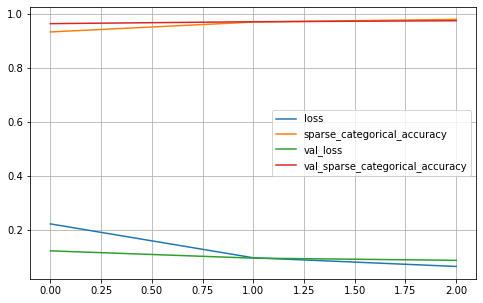

In [17]:
plot_training(history)

# Custom model and training process from scratch

Klasa tf.data.Dataset pełni formę Data loadera. Zawiera wszystkie podstawowe opcje takie jak wczytywanie, batchowanie, mieszanie danych itp. Opcje jak cache, czy prefetch pozwalają przyspieszyć cały proces podawania danych do modelu przygotowując dane równolegle do uczenia (wielowątkowo) i  zachowując dane w pamięci podręcznej.

In [18]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(64).cache().prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(buffer_size=1024).batch(64).cache().prefetch(1)

In [20]:
class MyModel(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(300, activation="relu")
        self.dense2 = keras.layers.Dense(100, activation="relu")
        self.output_layer = keras.layers.Dense(10, activation="softmax")

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.output_layer(x)

        return x

Główne elementy pętli uczącej (czyli train step i test step) mają dodany dodatkowo dektorator tf.function - dzięki temu funkcja pythone są kompilowane do statycznego grafu obliczeniowego co **znacznie** przyspiesza ich działanie (polecam usunąć dekorator i porównać). Jest to dość zaawansowana opcja i nie można każdej funkcji od tak skompilować do grafu statycznego, ta funkcja musi spełniać pewne warunki -- przede wszystkim nie można używać w środku nic co nie pochodzi z tensorflow (nie można nawet używać print, zamiast tego mamy tf.print)

Opisując natomiast sam krok uczący, jest on dość prosty i analogiczny do pętli wykorzystywanej w torchu. Główną różnicą względem PyTorch jest fakt, że w TensorFlow gradienty tensorów **nie** są domyślnie śledzone. Dlatego context managerem *tf.GradientTape()* włączamy śledzenie gradientu. Moim zdaniem to jest bardziej intuicyjne... W PyTorch jest dokładnie odwrotnie: gradienty są śledzone cały czas i wyłączamy to(np. do ewaluacji) context managerem *torch.no_grad()*.

In [21]:
@tf.function
def train_step(x, y, loss_fn, metric):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss_value = loss_fn(y, preds)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    metric.update_state(y, preds)
    return loss_value


@tf.function
def test_step(x, y, metric):
    val_logits = model(x, training=False)
    metric.update_state(y, val_logits)

Myślę, że sama funkcja fit jest dośc jasna. Jedyne ciekawostki tutaj to Progbar -- alternatywny do tqdm pasek postępu od TensorFlow (co ciekawe pozwala wypisywać metryki na samym pasku). Dodatkowo są tutaj używane metryki typu stateful. Jest to cała klasa, do której podaję tylko y_true i y_pred za pomocą metody update_state. Wszystko dzieje się w środku: liczenie, uśrednianie i zapamiętywanie całej historii metryki.

In [22]:
def fit(model, train_dataset, epochs, loss_fn):

    train_metric = keras.metrics.SparseCategoricalAccuracy()
    val_metric = keras.metrics.SparseCategoricalAccuracy()

    progress_bar = keras.utils.Progbar(epochs)
    for epoch in range(epochs):

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            train_step(x_batch_train, y_batch_train, loss_fn, train_metric)

        for x_batch_val, y_batch_val in val_dataset:
            test_step(x_batch_val, y_batch_val, val_metric)

        progress_bar.add(1, values=[('accuracy', train_metric.result()), ('val_accuracy', val_metric.result())])
        train_metric.reset_states()
        val_metric.reset_states()

In [23]:
model = MyModel()
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy()

In [24]:
fit(model, train_dataset, 5, loss_fn)

5/5 [==============================] - 6s 1s/step - accuracy: 0.9743 - val_accuracy: 0.9694
